# Example to use the Sherpa plugin with the sherpa interface

In this tutorial we show how to import a jetset model into Sherpa, and finally we perform a model fitting with Sherpa.
To run this plugin you have to install Sherpa: https://sherpa.readthedocs.io/en/latest/install.html


In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pylab as plt
import jetset
from jetset.test_data_helper import  test_SEDs
from jetset.data_loader import ObsData,Data
from jetset.plot_sedfit import PlotSED
from jetset.test_data_helper import  test_SEDs

In [2]:
test_SEDs

['/Users/orion/miniforge3/envs/jetset/lib/python3.10/site-packages/jetset/test_data/SEDs_data/SED_3C345.ecsv',
 '/Users/orion/miniforge3/envs/jetset/lib/python3.10/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk421_EBL_DEABS.ecsv',
 '/Users/orion/miniforge3/envs/jetset/lib/python3.10/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk501_EBL_ABS.ecsv',
 '/Users/orion/miniforge3/envs/jetset/lib/python3.10/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk501_EBL_DEABS.ecsv']

## Loading data



In [3]:
print(test_SEDs[2])
data=Data.from_file(test_SEDs[2])


/Users/orion/miniforge3/envs/jetset/lib/python3.10/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk501_EBL_ABS.ecsv



***  binning data  ***
---> N bins= 90
---> bin_widht= 0.2



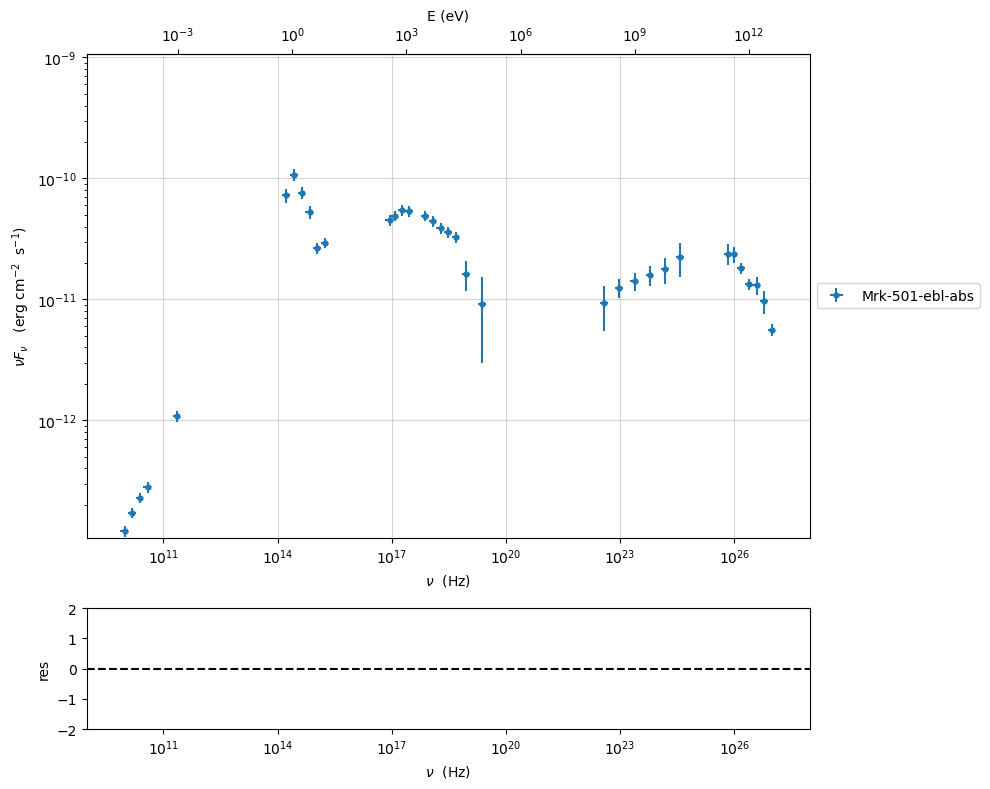

In [4]:
%matplotlib inline
sed_data=ObsData(data_table=data)
sed_data.group_data(bin_width=0.2)

sed_data.add_systematics(0.1,[10.**6,10.**29])
p=sed_data.plot_sed()

In [5]:
sed_data.save('Mrk_501.pkl')

## phenomenological model constraining

### spectral indices


*** evaluating spectral indices for data ***



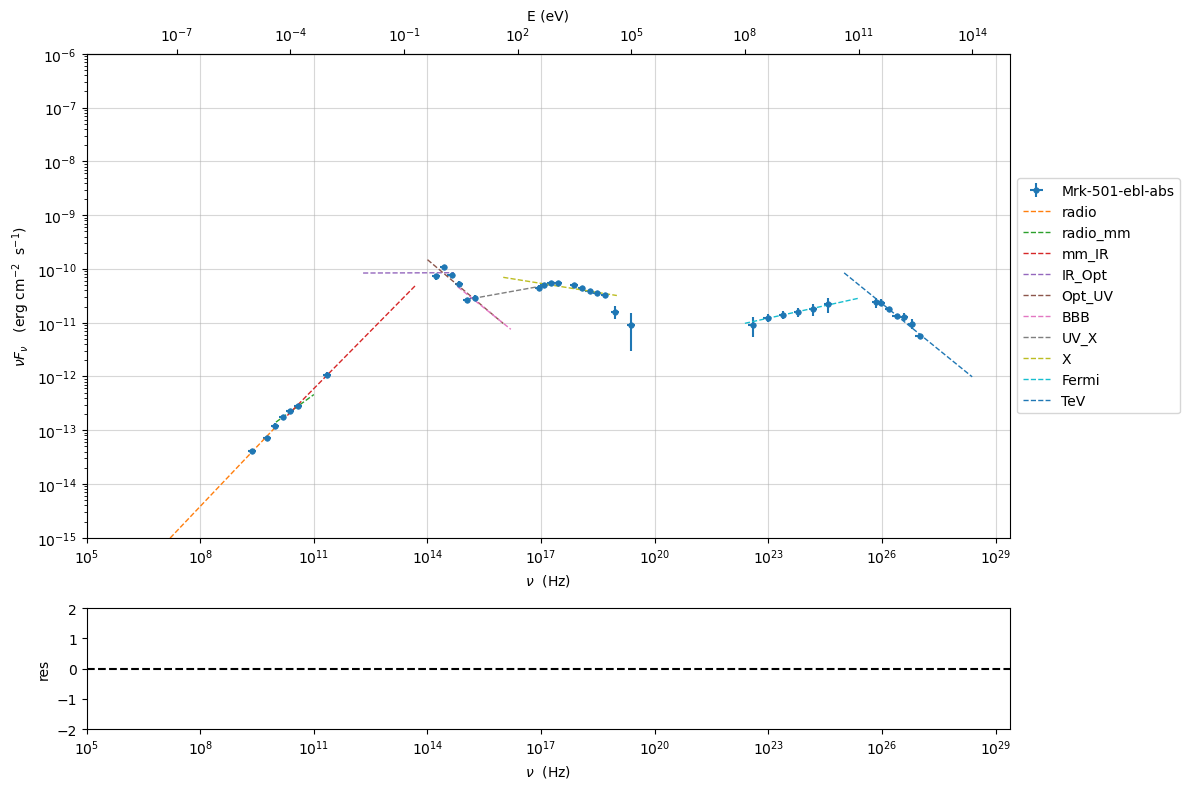

In [6]:
from jetset.sed_shaper import  SEDShape
my_shape=SEDShape(sed_data)
my_shape.eval_indices(minimizer='lsb',silent=True)
p=my_shape.plot_indices()
p.setlim(y_min=1E-15,y_max=1E-6)

### sed shaper

In [7]:
mm,best_fit=my_shape.sync_fit(check_host_gal_template=True,
                  Ep_start=None,
                  minimizer='lsb',
                  silent=True,
                  fit_range=[10.,21.])


*** Log-Polynomial fitting of the synchrotron component ***
---> first blind fit run,  fit range: [10.0, 21.0]
---> class:  HSP

---> class:  HSP




model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-6.522794e-02,-6.522794e-02,5.892905e-03,--,-4.913172e-02,-1.000000e+01,0.000000e+00,False
LogCubic,c,-1.908748e-03,-1.908748e-03,8.488797e-04,--,5.440153e-03,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,1.704833e+01,1.704833e+01,6.858392e-02,--,1.593204e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-1.030052e+01,-1.030052e+01,1.424853e-02,--,-1.022242e+01,-3.000000e+01,0.000000e+00,False
host_galaxy,nuFnu_p_host,-1.008538e+01,-1.008538e+01,2.900917e-02,--,-1.022242e+01,-1.222242e+01,-8.222416e+00,False
host_galaxy,nu_scale,1.934519e-02,1.934519e-02,1.919833e-03,--,0.000000e+00,-5.000000e-01,5.000000e-01,False


---> sync       nu_p=+1.704833e+01 (err=+6.858392e-02)  nuFnu_p=-1.030052e+01 (err=+1.424853e-02) curv.=-6.522794e-02 (err=+5.892905e-03)




*** Log-Polynomial fitting of the IC component ***
---> fit range: [23.0, 29.0]
---> LogCubic fit
====> simplex
====> migrad
====> simplex
====> migrad
====> simplex
====> migrad




model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-1.569967e-01,-1.569967e-01,2.511269e-02,--,-1.000000e+00,-1.000000e+01,0.000000e+00,False
LogCubic,c,-4.422595e-02,-4.422595e-02,2.000320e-02,--,-1.000000e+00,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,2.530691e+01,2.530691e+01,1.798034e-01,--,2.536233e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-1.058920e+01,-1.058920e+01,4.983735e-02,--,-1.000000e+01,-3.000000e+01,0.000000e+00,False


---> IC         nu_p=+2.530691e+01 (err=+1.798034e-01)  nuFnu_p=-1.058920e+01 (err=+4.983735e-02) curv.=-1.569967e-01 (err=+2.511269e-02)



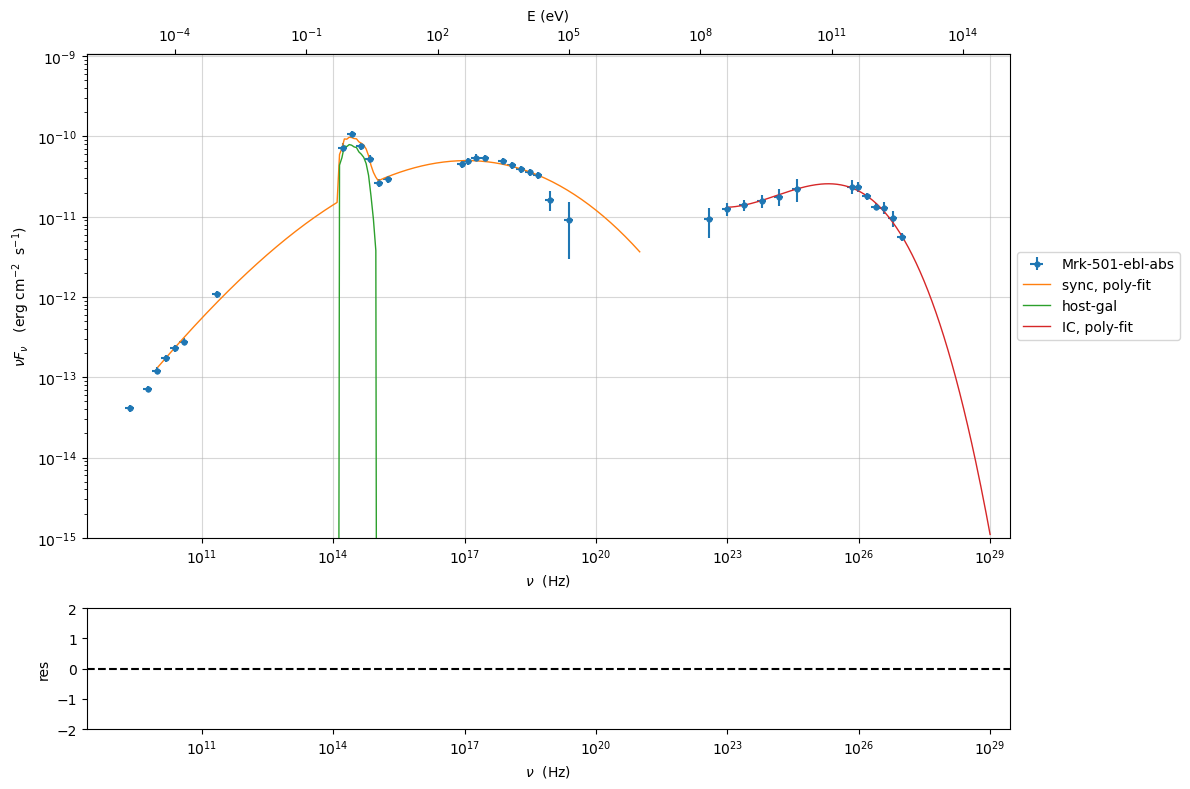

In [8]:
my_shape.IC_fit(fit_range=[23.,29.],minimizer='minuit',silent=True)
p=my_shape.plot_shape_fit()
p.setlim(y_min=1E-15)

### Model constraining

In this step we are not fitting the model, we are just obtaining the phenomenological `pre_fit` model, that will be fitted in using minuit ore least-square bound, as shown below

In [9]:
from jetset.obs_constrain import ObsConstrain
from jetset.model_manager import  FitModel
sed_obspar=ObsConstrain(beaming=25,
                        B_range=[0.001,0.1],
                        distr_e='lppl',
                        t_var_sec=3*86400,
                        nu_cut_IR=1E12,
                        SEDShape=my_shape)


prefit_jet=sed_obspar.constrain_SSC_model(electron_distribution_log_values=False,silent=True)
prefit_jet.save_model('prefit_jet.pkl')


***  constrains parameters from observable ***

===> setting C threads to 12


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,1.153385e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e+00,0.000000e+00,--,False,True
jet_leptonic,beam_obj,beaming,,2.500000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,3.360000e-02,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.703917e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.310708e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,5.311204e+00,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,1.107634e+04,1.000000e+00,1.000000e+09,False,False


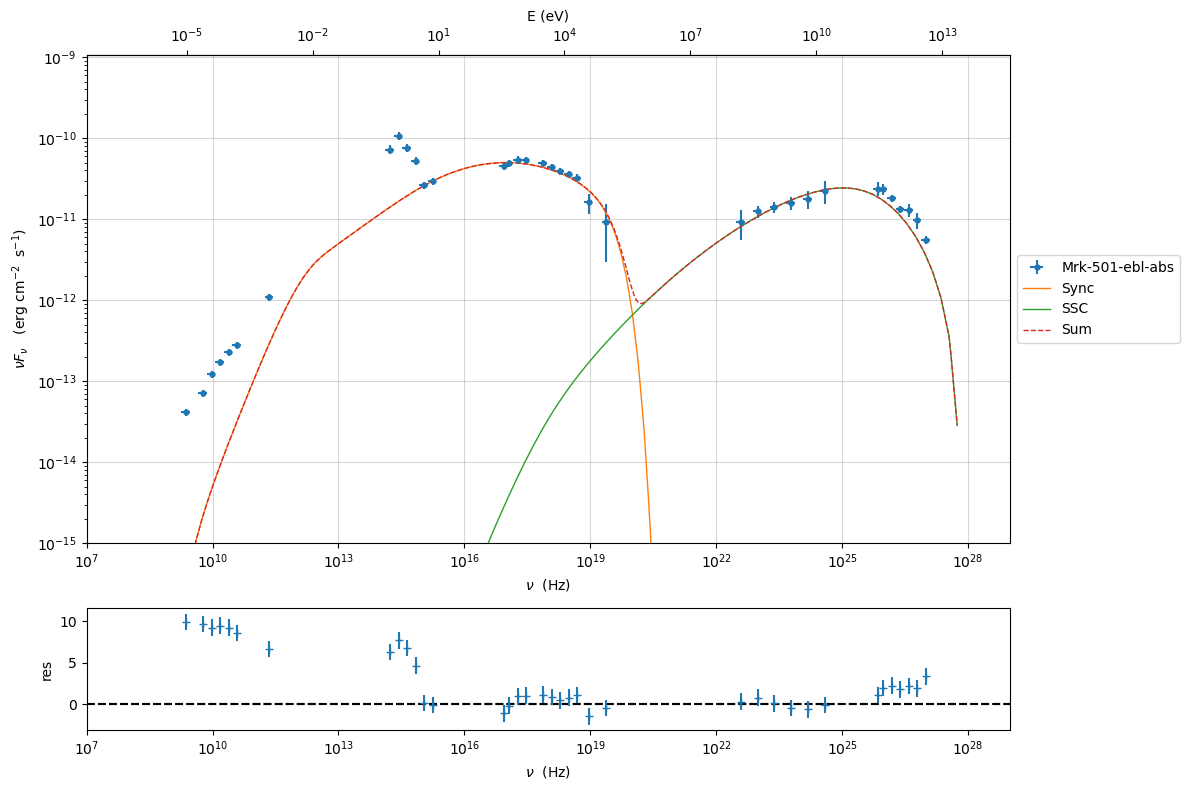

In [10]:
pl=prefit_jet.plot_model(sed_data=sed_data)
pl.add_model_residual_plot(prefit_jet,sed_data)
pl.setlim(y_min=1E-15,x_min=1E7,x_max=1E29)

## Model fitting with using a Sherpa model


we show now, how to import a jetset model into a Sherpa model

In [11]:
from jetset.sherpa_plugin import JetsetSherpaModel


In [12]:
from jetset.template_2Dmodel import EBLAbsorptionTemplate
ebl_franceschini=EBLAbsorptionTemplate.from_name('Franceschini_2008')

In [13]:
from jetset.jet_model import Jet
prefit_jet=Jet.load_model('prefit_jet.pkl')


===> setting C threads to 12


We remove the paramter `NH_cold_to_rel_e`, not used in the fit, because of problem  encountered with  the `IntervalProjection` Sherpa method

In [14]:
p=prefit_jet.parameters.get_par_by_name('NH_cold_to_rel_e')
prefit_jet.parameters.del_par(p)

The following instructions create a Sherpa model for each of the existing jetset models. 

In [15]:
sherpa_model_jet=JetsetSherpaModel(prefit_jet)
sherpa_model_gal=JetsetSherpaModel(my_shape.host_gal)
sherpa_model_ebl=JetsetSherpaModel(ebl_franceschini)



jetset model name R renamed to  R_sh due to sherpa internal naming convention


In [16]:
sherpa_model=(sherpa_model_jet+sherpa_model_gal)*sherpa_model_ebl

In [50]:
import pprint
sherpa_model

<BinaryOpModel model instance '((jet_leptonic + host_galaxy) * Franceschini_2008)'>

In [18]:
sherpa_model_ebl.z_cosm  = sherpa_model_jet.z_cosm

In [19]:
sherpa_model

<BinaryOpModel model instance '((jet_leptonic + host_galaxy) * Franceschini_2008)'>

In [20]:
sherpa_model_jet.R_H.freeze()
sherpa_model_jet.z_cosm.freeze()
sherpa_model_gal.nu_scale.freeze()
sherpa_model_ebl.scale_factor.freeze()

In [21]:

sherpa_model_jet.beam_obj.min = 5 
sherpa_model_jet.beam_obj.max = 50.

sherpa_model_jet.R_sh.min = 10**15. 
sherpa_model_jet.R_sh.max = 10**17.5

sherpa_model_jet.gmax.min = 1E5 
sherpa_model_jet.gmax.max = 1E7

sherpa_model_jet.gmin.min = 2
sherpa_model_jet.gmin.max = 1E3

sherpa_model_jet.s.min = 1.5
sherpa_model_jet.s.max = 3


sherpa_model_jet.r.min = 0.1
sherpa_model_jet.r.max = 2

In [22]:
sherpa_model

<BinaryOpModel model instance '((jet_leptonic + host_galaxy) * Franceschini_2008)'>

In [23]:
from sherpa import data
from sherpa.fit import Fit
from sherpa.stats import Chi2
from sherpa.optmethods import LevMar, NelderMead

In [24]:

sherpa_data=data.Data1D("sed", sed_data.table['nu_data'], sed_data.table['nuFnu_data'], staterror=sed_data.table['dnuFnu_data'])


In [25]:
fitter = Fit(sherpa_data, sherpa_model, stat=Chi2(), method=LevMar())
fit_range=[1e11,1e29]

sherpa_data.notice(fit_range[0], fit_range[1])


In [26]:
results = fitter.fit()

In [27]:
print("fit succeeded", results.succeeded)


fit succeeded True


In [28]:
results

Parameter,Best-fit value,Approximate error
jet_leptonic.gmin,291.65,± 184.611
jet_leptonic.gmax,2.12031e+06,± 0
jet_leptonic.N,6.2424,± 3.40544
jet_leptonic.gamma0_log_parab,5833.24,± 0
jet_leptonic.s,2.22829,± 0.113879
jet_leptonic.r,0.211095,± 0.0432467
jet_leptonic.R_sh,1.52236e+16,± 0
jet_leptonic.B,0.0109925,± 0.00346977
jet_leptonic.beam_obj,46.1322,± 8.84873
host_galaxy.nuFnu_p_host,-10.0879,± 0.0372766


In [29]:
sherpa_model

<BinaryOpModel model instance '((jet_leptonic + host_galaxy) * Franceschini_2008)'>

In [30]:
from jetset.sherpa_plugin import plot_sherpa_model


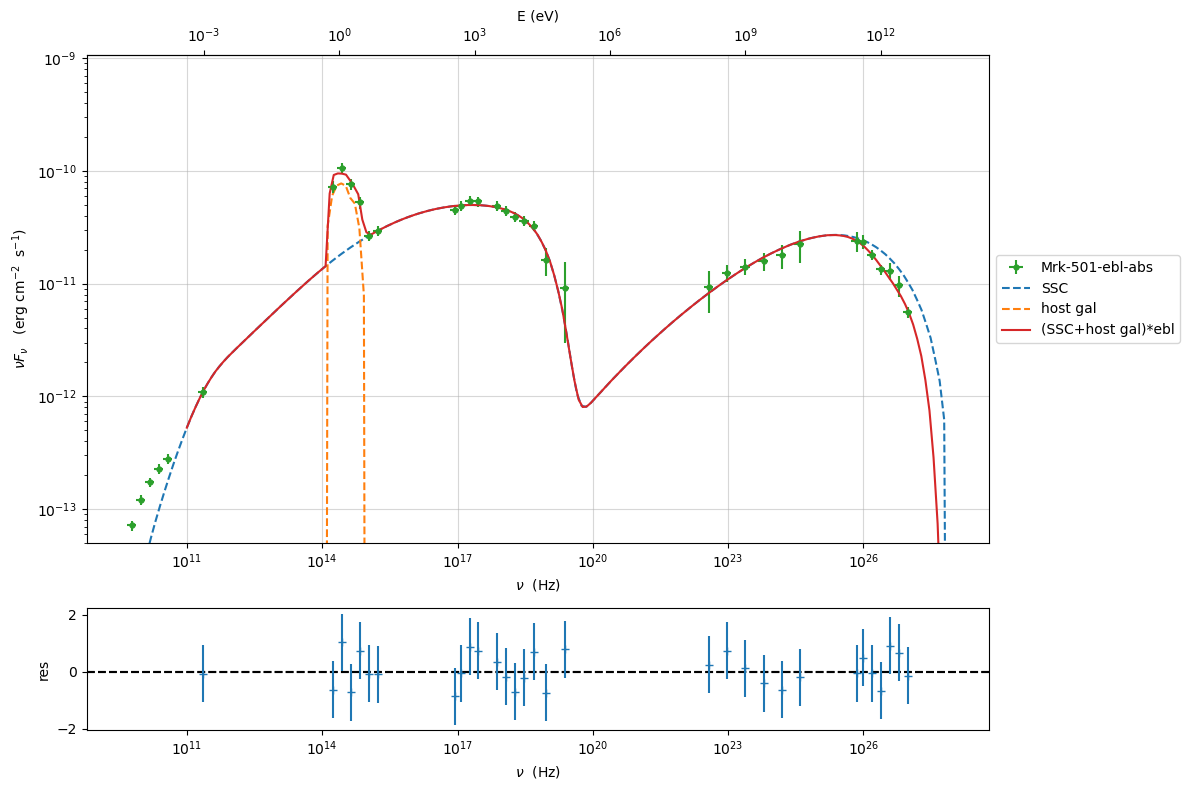

In [31]:
p=plot_sherpa_model(sherpa_model_jet,label='SSC',line_style='--')
p=plot_sherpa_model(sherpa_model_gal,plot_obj=p,label='host gal',line_style='--')
p=plot_sherpa_model(sherpa_model=sherpa_model,plot_obj=p,sed_data=sed_data,fit_range=fit_range,add_res=True,label='(SSC+host gal)*ebl')



You can access all the sherpa fetarues https://sherpa.readthedocs.io/en/latest/fit/index.html

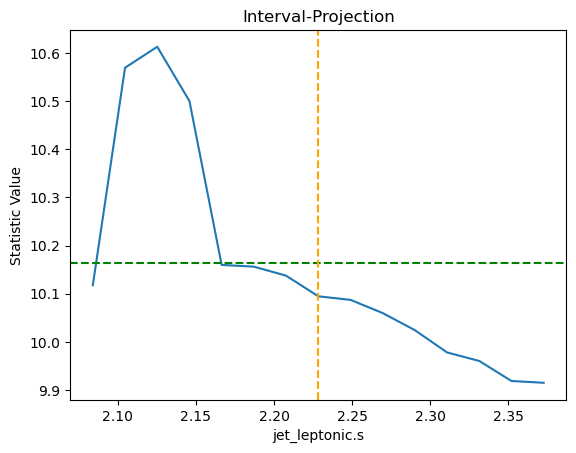

In [32]:
from sherpa.plot import IntervalProjection
iproj = IntervalProjection()
iproj.prepare(fac=5, nloop=15)
iproj.calc(fitter, sherpa_model_jet.s)
iproj.plot()